# Анализ тональности текста (Sentiment analysis). Валидация модели

В качестве моделей будут рассматриваться рекурентные нейронные сети

In [ ]:
!pip install -r requirements.txt

In [2]:
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix


warnings.filterwarnings('ignore')
np.random.seed(0)

def plot_roc_curve(y_pred, y_true) -> None:
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr)
    plt.axis([0,1,0,1])
    plt.title("ROC-кривая")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    print(f"ROC-AUC Score: {roc_auc_score(y_true, y_pred)}")

def plot_confusion_matrix(y_pred, y_true) -> None:
    cf_matrix = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cf_matrix, annot=True, cmap="Blues")
    ax.set_title("Матрица неточностей")
    ax.set_xlabel("Предсказанные значения")
    ax.set_ylabel("Действительные значения")
    plt.show()

def plot_history_nn(history) -> None:
    plt.plot(history.history['accuracy'], label="Точность на обучающем наборе")
    plt.plot(history.history['val_accuracy'], label="Точность на проверочном наборе")
    plt.xlabel("Эпоха обучения")
    plt.ylabel("Точность")
    plt.legend()
    plt.show()

In [3]:
train_data = pd.read_csv("./data/clear_train_data.csv")

In [4]:
train_data.head()

,comment,toxic
0,верблюдов дебилы бл,1.0
1,хохлы это отдушина затюканого россиянина мол в...,1.0
2,собаке собачья смерть,1.0
3,страницу обнови дебил это оскорбление доказанн...,1.0
4,убедил страничный пдф скрипалей отравила росси...,1.0


In [5]:
train_data["comment"] = train_data["comment"].astype(str)  # ошибка в токенизации, что возникает где-то float

In [6]:
train_data.shape

(14412, 2)

In [7]:
train_data.dtypes

comment     object
toxic      float64
dtype: object

In [8]:
X = train_data["comment"]
y = train_data["toxic"]

## Подготовка данных для обучения

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [10]:
# разбиваем текст на токены и создаем их последовательности
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_clean = pad_sequences(tokenizer.texts_to_sequences(X))

In [11]:
# разобьем выборку на обучающую и проверочную
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_clean, y, test_size=0.5)

In [12]:
X_train[:10]

array([[    0,     0,     0, ..., 18290, 12696,  7832],
       [    0,     0,     0, ...,  6590,  5773,   374],
       [    0,     0,     0, ..., 19772,   731, 21390],
       ...,
       [    0,     0,     0, ..., 62227, 25778, 12904],
       [    0,     0,     0, ..., 15240,  2553, 21485],
       [    0,     0,     0, ...,  9086,  3641,  2540]])

In [13]:
X_train.shape

(7206, 796)

In [14]:
y_train.shape

(7206,)

In [15]:
X_val.shape

(7206, 796)

## Создание и валидация моделей

In [16]:
from keras.models import Sequential
from keras.layers import (
    Dense,
    Embedding,
    LSTM,
    GRU,
    SimpleRNN,
)

### Простая рекурентная нейронная сеть

In [17]:
max_words = 100000

simple_model = Sequential()
simple_model.add(Embedding(max_words, 128))
simple_model.add(SimpleRNN(32, recurrent_dropout = 0.2))
simple_model.add(Dense(1, activation="sigmoid"))
simple_model._estimator_type = "classifier"

In [18]:
simple_model.compile(optimizer='rmsprop',  loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
simple_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         12800000  
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                5152      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 12,805,185
Trainable params: 12,805,185
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = simple_model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10
51/51 [==============================] - 24s 449ms/step - loss: 0.6847 - accuracy: 0.5599 - val_loss: 0.6438 - val_accuracy: 0.6380
Epoch 2/10
51/51 [==============================] - 23s 444ms/step - loss: 0.5700 - accuracy: 0.7153 - val_loss: 0.5869 - val_accuracy: 0.6810
Epoch 3/10
51/51 [==============================] - 22s 438ms/step - loss: 0.4026 - accuracy: 0.8384 - val_loss: 0.5148 - val_accuracy: 0.7490
Epoch 4/10
51/51 [==============================] - 22s 434ms/step - loss: 0.2293 - accuracy: 0.9278 - val_loss: 0.4405 - val_accuracy: 0.8017
Epoch 5/10
51/51 [==============================] - 23s 448ms/step - loss: 0.1342 - accuracy: 0.9588 - val_loss: 0.4605 - val_accuracy: 0.8031
Epoch 6/10
51/51 [==============================] - 23s 442ms/step - loss: 0.0801 - accuracy: 0.9773 - val_loss: 0.4623 - val_accuracy: 0.8225
Epoch 7/10
51/51 [==============================] - 23s 443ms/step - loss: 0.0420 - accuracy: 0.9883 - val_loss: 0.4960 - val_accuracy: 0.8058

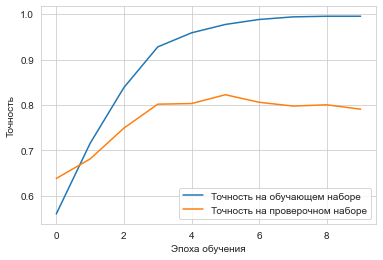

In [21]:
plot_history_nn(history)

In [22]:
y_pred = simple_model.predict(X_val)

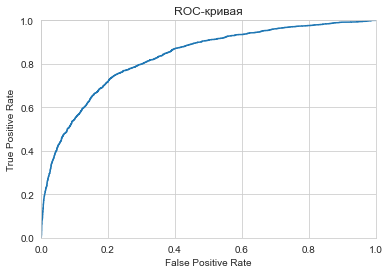

ROC-AUC Score: 0.8330023083462194


In [23]:
plot_roc_curve(y_pred, y_val)

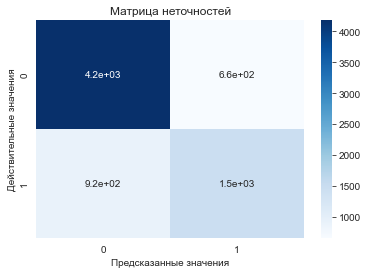

In [24]:
y_pred_int = [1 if pred[0] > 0.5 else 0 for pred in y_pred]  # так как предсказания в интервале 0 и 1, то будем считать, что 1 - больше 0.5, иначе - 0
plot_confusion_matrix(y_pred_int, y_val)

### Реккурентная сеть со слоем LSTM

In [25]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_words, 128))
model_lstm.add(LSTM(32, recurrent_dropout = 0.2))
model_lstm.add(Dense(1, activation="sigmoid"))

model_lstm.compile(optimizer='rmsprop',  loss='binary_crossentropy', metrics=['accuracy'])

In [26]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         12800000  
                                                                 
 lstm (LSTM)                 (None, 32)                20608     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,820,641
Trainable params: 12,820,641
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model_lstm.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10
51/51 [==============================] - 65s 1s/step - loss: 0.6098 - accuracy: 0.6754 - val_loss: 0.5661 - val_accuracy: 0.6921
Epoch 2/10
51/51 [==============================] - 62s 1s/step - loss: 0.3757 - accuracy: 0.8567 - val_loss: 0.4526 - val_accuracy: 0.7767
Epoch 3/10
51/51 [==============================] - 63s 1s/step - loss: 0.1973 - accuracy: 0.9451 - val_loss: 0.4043 - val_accuracy: 0.8308
Epoch 4/10
51/51 [==============================] - 63s 1s/step - loss: 0.1176 - accuracy: 0.9758 - val_loss: 0.3914 - val_accuracy: 0.8613
Epoch 5/10
51/51 [==============================] - 64s 1s/step - loss: 0.0658 - accuracy: 0.9867 - val_loss: 0.4052 - val_accuracy: 0.8558
Epoch 6/10
51/51 [==============================] - 63s 1s/step - loss: 0.0378 - accuracy: 0.9911 - val_loss: 0.4328 - val_accuracy: 0.8530
Epoch 7/10
51/51 [==============================] - 66s 1s/step - loss: 0.0246 - accuracy: 0.9934 - val_loss: 0.4753 - val_accuracy: 0.8571
Epoch 8/10
51/51 [==

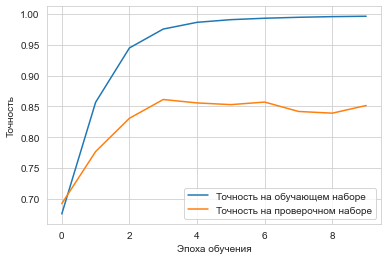

In [28]:
plot_history_nn(history)

In [29]:
y_pred = model_lstm.predict(X_val)

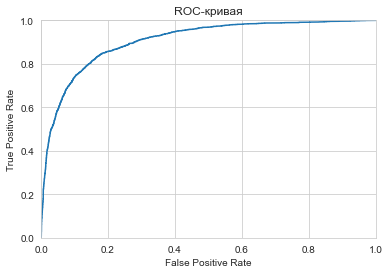

ROC-AUC Score: 0.9065345807298514


In [30]:
plot_roc_curve(y_pred, y_val)

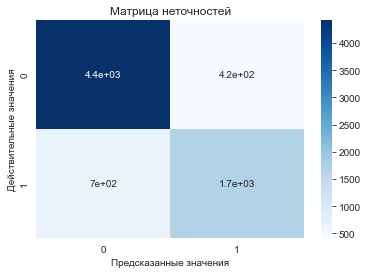

In [31]:
y_pred_int = [1 if pred[0] > 0.5 else 0 for pred in y_pred]  # так как предсказания в интервале 0 и 1, то будем считать, что 1 - больше 0.5, иначе - 0
plot_confusion_matrix(y_pred_int, y_val)

### Реккурентная сеть со слоем GRU

In [32]:
model_gru = Sequential()
model_gru.add(Embedding(max_words, 128))
model_gru.add(GRU(32, recurrent_dropout = 0.2))
model_gru.add(Dense(1, activation="sigmoid"))

model_gru.compile(optimizer='rmsprop',  loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         12800000  
                                                                 
 gru (GRU)                   (None, 32)                15552     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,815,585
Trainable params: 12,815,585
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model_gru.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

Epoch 1/10
51/51 [==============================] - 52s 989ms/step - loss: 0.5892 - accuracy: 0.6808 - val_loss: 0.5237 - val_accuracy: 0.7642
Epoch 2/10
51/51 [==============================] - 53s 1s/step - loss: 0.3141 - accuracy: 0.8992 - val_loss: 0.4722 - val_accuracy: 0.7892
Epoch 3/10
51/51 [==============================] - 52s 1s/step - loss: 0.1446 - accuracy: 0.9614 - val_loss: 0.4413 - val_accuracy: 0.7989
Epoch 4/10
51/51 [==============================] - 53s 1s/step - loss: 0.0748 - accuracy: 0.9798 - val_loss: 0.4451 - val_accuracy: 0.8405
Epoch 5/10
51/51 [==============================] - 52s 1s/step - loss: 0.0372 - accuracy: 0.9917 - val_loss: 0.4799 - val_accuracy: 0.8322
Epoch 6/10
51/51 [==============================] - 52s 1s/step - loss: 0.0219 - accuracy: 0.9938 - val_loss: 0.5526 - val_accuracy: 0.8322
Epoch 7/10
51/51 [==============================] - 51s 1s/step - loss: 0.0148 - accuracy: 0.9960 - val_loss: 0.5884 - val_accuracy: 0.8211
Epoch 8/10
51/51 

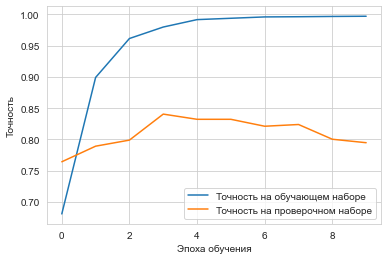

In [35]:
plot_history_nn(history)

In [36]:
y_pred = model_gru.predict(X_val)

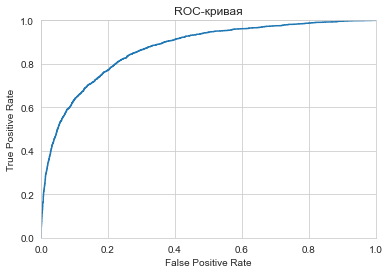

ROC-AUC Score: 0.8708514281490476


In [37]:
plot_roc_curve(y_pred, y_val)

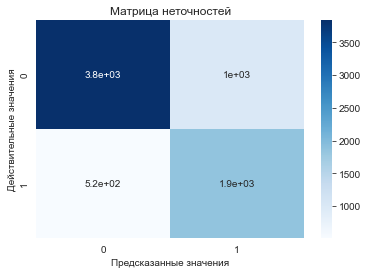

In [38]:
y_pred_int = [1 if pred[0] > 0.5 else 0 for pred in y_pred]  # так как предсказания в интервале 0 и 1, то будем считать, что 1 - больше 0.5, иначе - 0
plot_confusion_matrix(y_pred_int, y_val)

## Примеры

In [40]:
sample_data = train_data.sample(10)
X_sample = sample_data["comment"]
X_sample = pad_sequences(tokenizer.texts_to_sequences(X_sample))

In [41]:
y_simple_rnn = simple_model.predict(X_sample)
y_gru = model_gru.predict(X_sample)
y_lstm = model_lstm.predict(X_sample)

In [42]:
data = {
    "comment": sample_data["comment"].to_list(),
    "true_prediction": sample_data["toxic"].to_list(),
    "simple_rnn_prediction": [value[0] for value in y_simple_rnn],
    "gru_prediction": [value[0] for value in y_gru],
    "lstm_prediction": [value[0] for value in y_lstm],
}

In [43]:
pd.DataFrame(data)

,comment,true_prediction,simple_rnn_prediction,gru_prediction,lstm_prediction
0,скрутка самый долговечный способ археологи нах...,0.0,0.000051,0.000009,0.000068
1,ебись времена трехфазным током сильно скучаешь...,0.0,0.000375,0.000077,0.000180
2,смысле штатах игра выходит скидкой это крупней...,0.0,0.003065,0.000159,0.000369
3,курсанты записаться,0.0,0.017536,0.115222,0.131982
4,поймали коррупционера зарплате иметь квартиру ...,0.0,0.000550,0.000032,0.000120
5,дома холодильник лет работал фазе земле устана...,0.0,0.000384,0.000128,0.000057
6,извини тебе грязном ходить приятно,0.0,0.978548,0.997475,0.975283
7,потомок крепостного быдла это казанских татар ...,1.0,0.994861,0.999637,0.999589
8,курение замедляет процесс заживления насколько...,0.0,0.000111,0.000004,0.000097
9,время высыпаний могут определить вирус,0.0,0.046780,0.120331,0.001389
